In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import signal
from scipy import stats
from scipy import linalg

import sys
sys.path.insert(0,'..')
import specsens as ss

   infs left at  0.00%
 76.97s left at  0.33%
 78.78s left at  0.67%
 77.17s left at  1.00%
 78.70s left at  1.33%
 87.88s left at  1.67%
 79.92s left at  2.00%
 81.70s left at  2.33%
 74.97s left at  2.67%
 73.72s left at  3.00%
 74.17s left at  3.33%
 74.40s left at  3.67%
 72.88s left at  4.00%
 73.78s left at  4.33%
 72.77s left at  4.67%
 72.57s left at  5.00%
 71.90s left at  5.33%
 73.02s left at  5.67%
 72.67s left at  6.00%
 71.29s left at  6.33%
 70.55s left at  6.67%
 71.53s left at  7.00%
 71.77s left at  7.33%
 70.64s left at  7.67%
 70.70s left at  8.00%
 80.44s left at  8.33%
 73.02s left at  8.67%
 69.09s left at  9.00%
 68.51s left at  9.33%
 69.55s left at  9.67%
 68.80s left at 10.00%
 67.87s left at 10.33%
 68.19s left at 10.67%
 67.91s left at 11.00%
 67.54s left at 11.33%
 67.48s left at 11.67%
 66.92s left at 12.00%
 74.69s left at 12.33%
 72.06s left at 12.67%
 72.41s left at 13.00%
 77.85s left at 13.33%
 75.86s left at 13.67%
 72.88s left at 14.00%
 66.47s lef

/home/fabian/.local/lib/python3.6/site-packages/ipykernel_launcher.py:121: RuntimeWarning: invalid value encountered in double_scalars


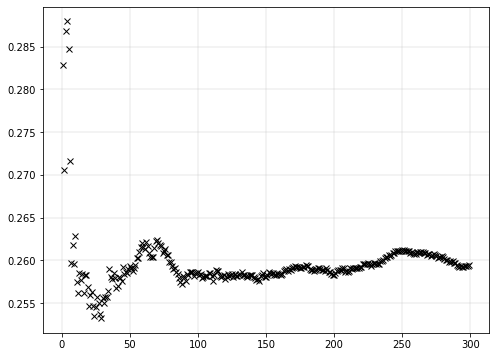

Theory     pfa 0.1
Simulation pfa 0.25932741256574265
Theory     pd  0.9577161904482208
Simulation pd  0.8019483796773282


In [81]:
import time


class MonteCarloSim():
    def __init__(self, gens, itrs):
        self.gens = gens  # Number of generations
        self.itrs = itrs  # NUmber of iterations per generation
        self.reset()

    def reset(self):
        self.pfas = list()  # Probability of false alarm list
        self.pds = list()  # Probability of detection list
        self.time = None

    def run(self,
            signal_strength=0.,
            noise_strength=0.,
            sample_freq=1e6,
            length=1.,
            pre_pfa=0.1):

        self.reset()
        n = 1024
        thr = ss.chi2_stats.get_thr(
            noise_power=ss.util.dB_to_factor_power(noise_strength),
            pfa=pre_pfa,
            #             n=ss.util.get_signal_length(f_sample=sample_freq, t_sec=length))
            n=1024)
        length = ss.util.sample_time(f_sample=sample_freq, num_samples=n)

        for i in range(self.gens):
            wm = ss.WirelessMicrophone(f_sample=sample_freq, t_sec=length)
            wgn = ss.WhiteGaussianNoise(f_sample=sample_freq, t_sec=length)

            correct_hit = 0
            false_hit = 0
            correct_miss = 0
            false_miss = 0
            times_signal_present = 0
            
            # As soon as we introduce noise uncertainty, the detector performs badly
            # This is expected, as energy detectors peform really badly with noise uncertainty
            #             noise_uncertainty = np.random.uniform(-1., 1.)
            noise_uncertainty = 0.

            for j in range(self.itrs):
                sig = wm.get_soft(f_center=1e5, dB=signal_strength)
                noise = wgn.get_signal(dB=noise_strength + noise_uncertainty)

                sig_present = bool(np.random.randint(2))
                if sig_present:
                    both = sig + noise
                    times_signal_present += 1
                else:
                    both = noise


#                 eng = ss.EnergyDetector.get(both)

#                 sft = ss.Stft(n=1024, window='box')
#                 f, t, x = sft.spectogram(sig=both, f_sample=sample_freq, normalized=False, dB=False)
#                 psd = x[:, 0]

                from scipy import fft
                f_welch, x_welch = signal.welch(both,
                                                sample_freq,
                                                nperseg=1024,
                                                noverlap=0,
                                                window='flattop',
                                                scaling='density',
                                                detrend=False,
                                                return_onesided=False)
                f = fft.fftshift(f_welch)
                psd = fft.fftshift(x_welch) * sample_freq

                #                 plt.figure(figsize=(8, 6))
                #                 plt.semilogy(f, psd)
                #                 plt.show()

                edf = ss.FreqEnergyDetector(num_bands=1,
                                            f_sample=1e6,
                                            fft_len=1024,
                                            freqs=f)
                eng = edf.detect(psd)[0]

                sig_detected = eng > thr

                if sig_present and sig_detected:
                    correct_hit += 1
                elif sig_present and not sig_detected:
                    false_miss += 1
                elif not sig_present and sig_detected:
                    false_hit += 1
                else:
                    correct_miss += 1

            pfa_tmp = false_hit / (self.itrs - times_signal_present)
            pd_tmp = correct_hit / times_signal_present
            self.pfas.append(pfa_tmp)
            self.pds.append(pd_tmp)
            rem, per = self.runtime_stats(self.gens, i)
            print('%6.2fs left at %5.2f%%' % (rem, per))

        pfa = np.sum(self.pfas) / self.gens
        pd = np.sum(self.pds) / self.gens
        return pfa, pd

    def runtime_stats(self, total_itr, current_itr):
        if self.time is None:
            self.time = time.time()
            return float('inf'), 0.0
        delta_time = time.time() - self.time
        self.time = time.time()
        remaining_itr = total_itr - current_itr
        remaining_time = delta_time * remaining_itr
        percent_done = current_itr / total_itr * 100.0
        return remaining_time, percent_done

    def print_convergence(self):
        plt.figure(figsize=(8, 6))
        plt.grid(linewidth=0.3)
        for i in range(self.gens):
            inter = np.sum(self.pfas[0:i]) / i
            plt.plot(i, inter, 'kx')
        plt.show()

sim = MonteCarloSim(300, 300)
pfa, pd = sim.run(signal_strength=0.,
                  noise_strength=10.,
                  sample_freq=1e6,
                  length=0.002,
                  pre_pfa=0.1)

sim.print_convergence()

print(f'Theory     pfa {0.1}')
print(f'Simulation pfa {pfa}')
print(
    f'Theory     pd  {ss.chi2_stats.get_pd(ss.util.dB_to_factor_power(10.), ss.util.dB_to_factor_power(0.), ss.chi2_stats.get_thr(10., 0.1, ss.util.get_signal_length(f_sample=1e6, t_sec=0.001)), ss.util.get_signal_length(f_sample=1e6, t_sec=0.001))}'
)
print(f'Simulation pd  {pd}')